# [Artificial Neural Networks - Assignment](https://docs.google.com/viewer?a=v&pid=sites&srcid=ZGVmYXVsdGRvbWFpbnxhcnRpZmljaWFsbmV1cmFsbmV0d29ya3Nhbm58Z3g6MzZmMzBjY2ZmN2EyMmMyYQ)


## Q1.
a. Create the Multi-layer Perceptron Neural Network / Back-propagation network from scratch in Python using the weight and bias updation for solving the classification Problem. Also check the linear Separability for AND and XOR problem using the created Multi-layer Perceptron Neural Network algorithm/ Back propagation network.

- **Note:-** Carry out leave-one-out cross-validation (LOOCV) and K-Fold Cross Validationon a simple classification problem. Discuss the best approach amongst the same.

b. Try to Modify the weight and bias updation formula by changing or removing the learning rate used in the Multi-layer Perceptron Neural Network / Back-propagation network to check the impact on the overall performance of the network

## Q2.

Implement the problem mentioned below in Python and also try to modify the created network for the given problem by increasing the number of layers in network to check the impact on the overall performance of the model.

**Problem:-**
A network is created when we multiple neurons stack together. Let us take an example of a neural network simulating an XNOR function.

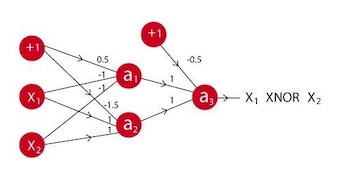

You can see that the last neuron takes input from two neurons before it. The activation function for all the neurons is given by:

$ f(x) = \left\{ \begin{array}{ll}
      0 & for & x\leq 0 \\
      1 & for & x\geq 0 \\
\end{array}
\right. $

Suppose X1 is 0 and X2 is 1, what will be the output for the above neural network? <br/>
A) 0 <br/>
B) 1

In [1]:
import numpy as np
from typeguard import typechecked
from typing import List, Callable, Union

Feed forward network layer.

In [2]:
class Layer:
    @typechecked
    def __init__(self, w: np.ndarray, b: np.ndarray, 
                 activation: Union[Callable, None] = None):
        assert w.ndim == 2, "Weights must be 2D matrix"
        assert b.ndim == 1, "Biases must be 1D vector"
        assert w.shape[0] == b.shape[0], "Weights and biases must"\
            " conform to same number of neurons"

        self.weights = w
        self.biases = b

        self.activation = activation
    
    def get_size(self):
        output_size, input_size = self.weights.shape
        return input_size, output_size

    @typechecked
    def forward(self, inputs: np.ndarray) -> np.ndarray:
        n_samples, n_features = inputs.shape

        assert n_features == self.weights.shape[-1], "Inputs must be a"\
            f" n x {n_features} matrix"
        n_neurons = self.weights.shape[0]

        ones = np.ones((n_samples, 1))
        
        inputs = np.hstack([ones, inputs])
        b = np.expand_dims(self.biases, -1)
        wb = np.hstack([b, self.weights])

        output = inputs @ wb.T
        if self.activation is not None:
            return self.activation(output)
        else:
            return output

    @typechecked
    def __call__(self, inputs: np.ndarray) -> np.ndarray:
        return self.forward(inputs)

Set random seed for determininstic results.

In [3]:
np.random.seed(7)

In [4]:
n_samples = 10
n_features = 5
n_neurons = 3

X = np.random.normal(size=(n_samples, n_features))
w = np.random.random(size=(n_neurons, n_features))
b = np.random.random(size=(n_neurons, ))

In [5]:
layer1 = Layer(w, b)
layer1_output = layer1(X)
assert layer1.get_size() == (n_features, n_neurons)

In [6]:
class Net:
    @typechecked
    def __init__(self, layers: List[Layer]):
        assert len(layers) > 0, "Number of layers should be atleast one"
        Net.check_shapes(layers)
        self.layers = layers
    
    @staticmethod
    def check_shapes(layers: List[Layer]):
        prev_layer = layers[0]
        for layer in layers[1:]:
            _, prev_output = prev_layer.get_size()
            this_input, _ = layer.get_size()
            
            assert prev_output == this_input, "Layer input size must exactly"\
                " match output shape of the preceeding layer"
            
            prev_layer = layer
    
    @typechecked
    def forward(self, inputs: np.ndarray):
        for layer in self.layers:
            inputs = layer.forward(inputs)
        return inputs
    
    @typechecked
    def __call__(self, inputs: np.ndarray):
        return self.forward(inputs)

In [7]:
n_samples = 10
n_features = 5
n_neurons_layer1 = 3
n_neurons_layer2 = 5
n_neurons_layer3 = 1

X = np.random.normal(size=(n_samples, n_features))

w1 = np.random.random(size=(n_neurons_layer1, n_features))
b1 = np.random.random(size=(n_neurons_layer1, ))

w2 = np.random.random(size=(n_neurons_layer2, n_neurons_layer1))
b2 = np.random.random(size=(n_neurons_layer2, ))

w3 = np.random.random(size=(n_neurons_layer3, n_neurons_layer2))
b3 = np.random.random(size=(n_neurons_layer3, ))

In [8]:
identity = lambda x: x
relu = lambda x: np.maximum(x, 0)

In [9]:
layer1 = Layer(w1, b1, relu)
layer2 = Layer(w2, b2, relu)
layer3 = Layer(w3, b3, identity)

In [10]:
y = layer3(layer2(layer1(X)))
y

array([[1.00138383],
       [5.68665987],
       [5.45742112],
       [4.30953155],
       [5.96850311],
       [5.2887552 ],
       [6.18013203],
       [2.46759842],
       [8.05767774],
       [5.08341227]])

In [11]:
net = Net([layer1, layer2, layer3])
assert all(net(X) == y)
net(X)

array([[1.00138383],
       [5.68665987],
       [5.45742112],
       [4.30953155],
       [5.96850311],
       [5.2887552 ],
       [6.18013203],
       [2.46759842],
       [8.05767774],
       [5.08341227]])

Step activation function is defined as:
$ f(x) = \left\{ \begin{array}{ll}
      0 & for & x\leq 0 \\
      1 & for & x\geq 0 \\
\end{array}
\right. $

In [12]:
step = lambda x: (x > 0).astype(x.dtype)

In [31]:
x1 = 0
x2 = 1

w1 = np.array([[-1, -1], [1, 1]])
b1 = np.array([0.5, -1.5])

w2 = np.array([[1, 1]])
b2 = np.array([-0.5])

In [32]:
hidden_layer = Layer(w1, b1, step)
output_layer = Layer(w2, b2, step)
xnor_net = Net([hidden_layer, output_layer])

In [33]:
X = np.array([[x1, x2]])

In [34]:
h = hidden_layer(X)
h

array([[0., 0.]])

In [35]:
t = output_layer(h)
t

array([[0.]])

In [36]:
y = xnor_net(X)
assert all(y == t)
y

array([[0.]])

**XNOR Truth Table**

The XNOR function gives high output (1) results if both of the inputs to the function are the same.

| $ x1 $ | $ x2 $ | $ x1 $ &#9737; $ x2 $ |
| --- | --- | --- |
| 0 | 0 | **1** |
| 0 | 1 | **0** |
| 1 | 0 | **0** |
| 1 | 1 | **1** |

In [37]:
X = np.array([[0, 0], 
              [0, 1], 
              [1, 0], 
              [1, 1]])
xnor_net(X)

array([[1.],
       [0.],
       [0.],
       [1.]])

## Q3.
In training a neural network, you notice that the loss does not decrease in the few starting epochs.

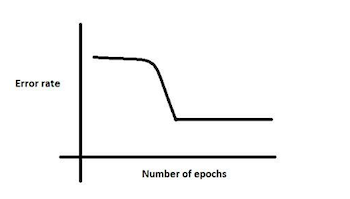

The reasons for this could be:
1. The learning is rate is low
2. Regularization parameter is high
3. Stuck at local minima

What according to you are the probable reasons? Justify your answer regarding the same.

## Q4.
Build and train a ConvNet in Python using TensorFlow / keras for an image classification problem and explain each and every line in the comment section.  Also, try to improve the performance of the model by applying various hyper parameter tuning to reduce the overfitting or under fitting problem that might occur.

## Q5.
Write code in Python to perform object detection using CNN. Also, discuss about various performance evaluation parameters to measure the performance of the object detection algorithms.

## Q6.
Build a neural network architecture from scratch in Python and perform the multi-class classification task on data of your choice.

Parameters to be considered while creating the neural network from scratch are specified as:
1. No of hidden layers : 1 or more
2. No. of neurons in hidden layer: 100 
3.  Non-linearity in the layer : Relu 
4. Use more than 1 neuron in the output layer. Use a suitable threshold value.
5. Optimisation algorithm : Stochastic Gradient Descent (SGD) 
6.  Loss function : categorical cross entropy loss 
**Note :-** Do not use any external python library.

Do a random initialization of the weights. And use the learning rate value as 0.1 while conducting the experiment.